<a href="https://colab.research.google.com/github/YufenLin/personal_sommelier/blob/runwholedata/notebooks/personal_sommelier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Personal Sommelier

## The data consists of 13 fields:
(UPDATED 11/24/2017)

* Points: the number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)
* Title: the title of the wine review, which often contains the vintage if you're interested in extracting that feature
* Variety: the type of grapes used to make the wine (ie Pinot Noir)
* Description: a few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
* Country: the country that the wine is from
* Province: the province or state that the wine is from
* Region 1: the wine growing area in a province or state (ie Napa)
* Region 2: sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank
* Winery: the winery that made the wine
* Designation: the vineyard within the winery where the grapes that made the wine are from
* Price: the cost for a bottle of the wine
* Taster Name: name of the person who tasted and reviewed the wine
* Taster Twitter Handle: Twitter handle for the person who tasted ane reviewed the wine


## import library

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle


In [0]:
# google colab
import io
from google.colab import files

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#force output to display the full description
# pd.set_option('display.max_colwidth', -1)

In [0]:
# # google colab
# from google.colab import files
# uploaded = files.upload()
# # google colab
# wine_data = pd.read_csv(io.BytesIO(uploaded['winemag-data-130k-v2.csv']))

Saving winemag-data-130k-v2.csv to winemag-data-130k-v2.csv


In [0]:
# google colab
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# google colab
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
link = 'https://drive.google.com/open?id=1VZ8ZZEhkSH3of8jIiokudu8ur_sFO6xp'
fluff, id = link.split('=')
# print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('winemag-data-130k-v2.csv')  
wine_data = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)

In [0]:
wine_data.shape

(129971, 13)

In [0]:
# wine_data = pd.read_csv("../data/raw/wine-reviews/winemag-data-130k-v2.csv")
# wine_data.rename(columns={'Unnamed: 0': 'wineid'},inplace=True)

In [0]:
#create connection to database
# conn = sqlite3.connect('db\wine_data.sqlite')
# c = conn.cursor()

In [0]:
wine_data['Unnamed: 0'].is_unique # The first column in csv is unique

True

In [0]:
wine_data['country'] = wine_data['country'].fillna("Unknown")
wine_data['designation'] = wine_data['designation'].fillna("Unknown")
wine_data['province'] = wine_data['province'].fillna("Unknown")
wine_data['region_1'] = wine_data['region_1'].fillna("Unknown")
wine_data['region_2'] = wine_data['region_2'].fillna("Unknown")
wine_data['taster_name'] = wine_data['taster_name'].fillna("Unknown")
wine_data['taster_twitter_handle'] = wine_data['taster_twitter_handle'].fillna("Unknown")
wine_data['variety'] = wine_data['variety'].fillna("Unknown")
wine_data['price'] = wine_data['price'].fillna(0)

In [0]:
# 9983
# duplicated_test = ['country', 'title', 'taster_name', 'points','description']
duplicated_test = list(wine_data.columns)
result = wine_data.duplicated('country')
for col in duplicated_test:
  result = result & wine_data.duplicated(col)
wine_data[result].shape

# There is 9983 records is exactly same.

(9983, 13)

In [0]:
# drop same records
idx = wine_data[result].index
wine_data.drop(idx , inplace=True)

In [0]:
129971 - 9983

119988

In [0]:
wine_data.shape

(119988, 13)

In [0]:
wine_data[wine_data.duplicated('description')].shape
# There is still 33 records have same description

(33, 13)

In [0]:
 wine_data[wine_data.duplicated('description') & wine_data.duplicated('title')].shape
 # It is for different wine. Therefore, keep duplicate description.

(0, 13)

In [0]:
# wine_data.to_sql('wine_data', conn, if_exists = "replace")

In [0]:
wine_data.isna().sum() # no "taster_name", "taster_twitter_handle"

country                  0
description              0
designation              0
points                   0
price                    0
province                 0
region_1                 0
region_2                 0
taster_name              0
taster_twitter_handle    0
title                    0
variety                  0
winery                   0
dtype: int64

In [0]:
wine_data.to_csv('wine_data_119988_processed.csv') 
files.download('wine_data_119988_processed.csv')

In [0]:
# wine150k = pd.read_csv("../data/raw/wine-reviews/winemag-data_first150k.csv", index_col=0)

In [0]:
# wine_sample = wine_data.sample(n=10000, random_state=2020)

In [0]:
# wine_sample = wine_data.head(10000)

## import from processed data

In [0]:
# google colab
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1OEQOUs4sC2MdXzbI6a-81GBznvkXKrvt'
fluff, id = link.split('=')
# print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('wine_data_119988_processed.csv')  
wine_sample = pd.read_csv('wine_data_119988_processed.csv').iloc[:,1:]

In [126]:
wine_sample.shape 
#(119988, 13)

(119988, 13)

In [127]:
wine_sample.isna().sum()

country                  0
description              0
designation              0
points                   0
price                    0
province                 0
region_1                 0
region_2                 0
taster_name              0
taster_twitter_handle    0
title                    0
variety                  0
winery                   0
dtype: int64

## rating distribution
* All points has value. 
* 80 - 100 

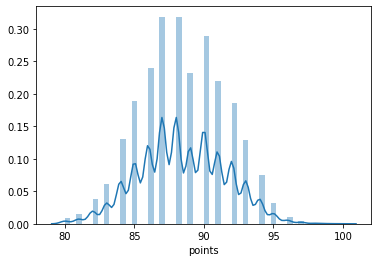

In [0]:
sns.distplot(wine_sample['points']);

In [0]:
wine_sample['points'].describe()

count    119988.000000
mean         88.442236
std           3.092915
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

## rating distribution
* max price: 3300

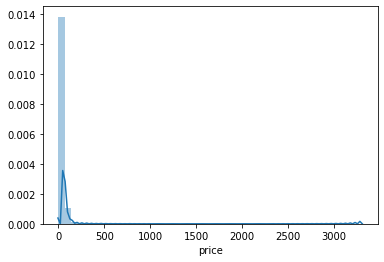

In [0]:
sns.distplot(wine_sample['price']);

In [0]:
wine_price_0_200 = wine_sample[(wine_sample['price']>0) & (wine_sample['price']<200)]
wine_price_200_1000 = wine_sample[(wine_sample['price']>200) & (wine_sample['price']<1000)]
wine_price_1000_2000 = wine_sample[(wine_sample['price']>1000) & (wine_sample['price']<2000)]
wine_price_2000_3300 = wine_sample[(wine_sample['price']>2000) & (wine_sample['price']<=3300)]

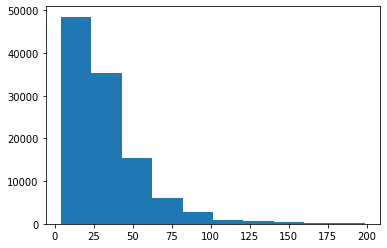

In [0]:
plt.hist(wine_price_0_200['price']);

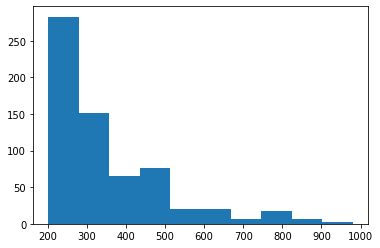

In [0]:
plt.hist(wine_price_200_1000['price']);

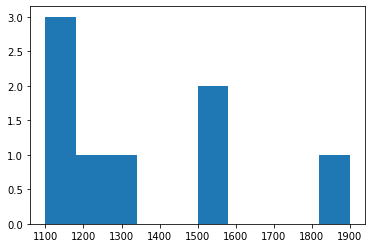

In [0]:
plt.hist(wine_price_1000_2000['price']);

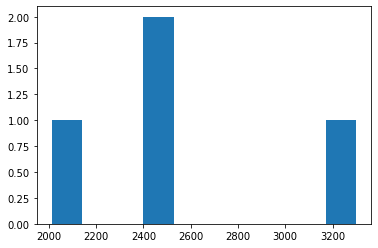

In [0]:
plt.hist(wine_price_2000_3300['price']);

## price - rating distribution

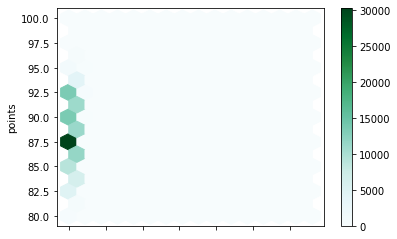

In [0]:
wine_sample.plot.hexbin(x='price', y='points', gridsize=15);

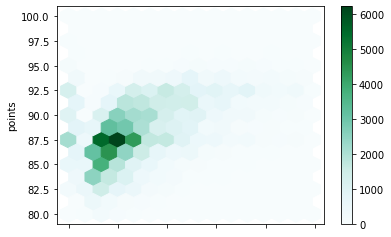

In [0]:
wine_sample[wine_sample['price'] < 100].plot.hexbin(x='price', y='points', gridsize=15);

## description word count distribution. It is normal distribution.

In [0]:
wine_sample['word_count'] = wine_sample['description'].apply(lambda x: len(str(x).split(" ")))
wine_sample['word_count'].describe()

count    119988.000000
mean         40.423626
std          11.205306
min           3.000000
25%          33.000000
50%          40.000000
75%          47.000000
max         135.000000
Name: word_count, dtype: float64

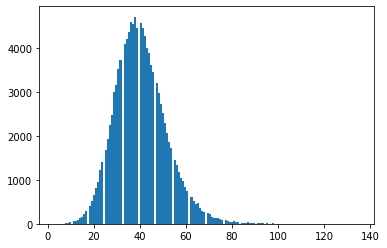

In [0]:
#set x for the histogram and set bins based on max 
x = wine_sample['word_count']
n_bins = 150
#plot histogram
plt.hist(x, bins=n_bins)
plt.show()

## clean description

In [0]:
# ! pip install nltk

In [0]:
# ! pip install punkt

ERROR: Could not find a version that satisfies the requirement punkt (from versions: none)
ERROR: No matching distribution found for punkt


In [0]:
import re
import nltk
from nltk.corpus import stopwords

In [10]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
#add list of words to stoplist

stop_words = set(stopwords.words("english"))

#add single word to stoplist
add_stopwords = ["wine", "drink"]
stop_words = stop_words.union(add_stopwords)
print(len(stop_words))
# 181

181


In [12]:
#loops through descriptions and cleans them
clean_desc_w_stop = []
for index, row in wine_sample.iterrows():
    desc = row['description'].lower()
    #remove punctuation
    desc = re.sub('[^a-zA-Z]', ' ', desc)
    #remove tags
    desc = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)

    #remove digits and special chars
    desc = re.sub("(\\d|\\W)+"," ",desc)
    
    clean_desc_w_stop.append(desc)
#assign the cleaned descriptions to the data frame
wine_sample['clean_desc_w_stop'] = clean_desc_w_stop

NameError: ignored

In [0]:
def remove_stopwords(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed 

In [0]:
# %%time 
# 30sec
clean_desc_wo_stopwords = list(map(remove_stopwords, clean_desc_w_stop))
wine_sample['clean_desc_wo_stop'] = clean_desc_wo_stopwords

In [133]:
wine_sample.shape

(119988, 15)

In [134]:
wine_sample.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
clean_desc_w_stop         object
clean_desc_wo_stop        object
dtype: object

In [0]:
wine_sample.to_pickle("wine_sample_clean_desc.pkl")
files.download('wine_sample_clean_desc.pkl')

In [22]:
wine_sample.shape

(119988, 15)

In [23]:
wine_sample.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,clean_desc_w_stop,clean_desc_wo_stop
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,0.0,Sicily & Sardinia,Etna,Unknown,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,aromas include tropical fruit broom brimstone ...,"[aromas, include, tropical, fruit, broom, brim..."
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Unknown,Unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,this is ripe and fruity a wine that is smooth ...,"[ripe, fruity, smooth, still, structured, firm..."


## flavor keywords

In [0]:
# google colab
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1PjnUCWBpA6GuWcz6UwHiq0oqNsrKVZah'
fluff, id = link.split('=')
# print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('wine_sample_clean_desc.pkl')  
wine_sample = pd.read_pickle("wine_sample_clean_desc.pkl")

In [148]:
wine_sample.shape
# (119988, 15)

(119988, 15)

In [149]:
wine_sample.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,clean_desc_w_stop,clean_desc_wo_stop
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,0.0,Sicily & Sardinia,Etna,Unknown,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,aromas include tropical fruit broom brimstone ...,"[aromas, include, tropical, fruit, broom, brim..."
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Unknown,Unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,this is ripe and fruity a wine that is smooth ...,"[ripe, fruity, smooth, still, structured, firm..."


In [0]:
# "herbaceous" -> "herb"
pri_words = ["fruit", "spicy", "floral", "microbiological", "oxidized", "pungent",
                "chemical","earthy","woody","caramel","nutty","herb","vegetative"]
# "spicy","floral","oxidized","pungent","earthy", "caramel", "nutty", "fruit"
sec_words = ["citrus","berry","tree","tropic","dried",
             "yeasty","lactic","cool","hot","sulfur",
             "petroleum","moldy","burned","phenolic","resinous",
             "fresh","canned","cooked"]

ter_words = [#fruity
    "grapefruit", "lemon", "blackberry", "raspberry", "strawberry", "currant",
    "cassis","cherry", "apricot", "peach", "apple", "pineapple", "melon", "banana",
    "jam", "raisin", "prune", "fig", "candied", "concord", "artificial", 
    "methyl", "anthranilate", 
    
    # spicy
    "licorice", "anise", "pepper", "cloves", 
    # floral
    "geranium", "violet", "rose","orange", "blossom",
    # mocribiological     
    "leesy", "baker", "yoghurt", "sweaty", "sauerkraut", "mousy", "horsey", "champagne"
    # oxidized 
    "oxidized", 
    # pungent
    "menthol", "alcohol", "rubbing",
    # chemical: "sulfur",
    "dioxide", "ethanol", "acetic", "grain","vinegar", "acid", 
    "polish", "ethyl", "wool", "dog", "match", "cabbage", "skunk", 
    "garlic", "gas", "mercaptan", "egg","hydrogen", "rubbery", "diesel", "kerosene",
    "plastic", "tar", "acetate",
    # earthy: "moldy"
    "cork", "mildew", "mushroom", "dusty", 
    # woody: "phenolic"
    "smoky", "burnt", "toast", "coffee", "medicinal", "bandaid", "sawdust", 
    "bacon", "oak", "cedar", "vanilla", 
    # caramel
    "honey", "butterscotch", "diacetyl", "soy", "sauce", "chocolate", "molasses", 
    # nutty
    "walnut", "hazelnut", "almond",
    # herbaceous/vegetative: "pepper"
    "grass", "eucalyptus", 
    "mint", "beans", "asparagus", "olive", "artichoke", "hay", "straw",
    "tea", "tobacco",

    #my add
    "tart", "cranberry", "savory"
    ]

In [0]:
flavor_words_list =  pri_words + sec_words + ter_words

In [15]:
len(flavor_words_list)

137

In [0]:
from collections import Counter
Counter(flavor_words_list)

In [154]:
'herb' in flavor_words_list

True

## Lemmatizing and Stemming

In [0]:
# nltk.download('wordnet')

In [0]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [0]:
# lem = WordNetLemmatizer()
# pri_words_lem = [lem.lemmatize(word) for word in pri_words] 
# sec_words_lem = [lem.lemmatize(word) for word in sec_words] 
# ter_words_lem = [lem.lemmatize(word) for word in ter_words] 
# flavor_words_lem = [lem.lemmatize(word) for word in flavor_words_list] 
stm = SnowballStemmer("english")
pri_words_stem = [stm.stem(word) for word in pri_words] 
sec_words_stem = [stm.stem(word) for word in sec_words] 
ter_words_stem = [stm.stem(word) for word in ter_words] 
flavor_words_stem = [stm.stem(word) for word in flavor_words_list] 

In [0]:
def flavor_words_func(words):
    tokens = nltk.word_tokenize(words)
    stm = SnowballStemmer("english")
    flavor_words_list = [stm.stem(token) for token in tokens if stm.stem(token) in flavor_words_stem  ]
    return flavor_words_list
# def flavor_words_func_backup(words):
#     tokens = nltk.word_tokenize(words)
#     stm = SnowballStemmer("english")
#     flavor_words_list = [stm.stem(token) for token in tokens if token in flavor_words_stem]
#     return flavor_words_list

In [0]:
# %%time 
# 1m42s
flavor_words_temp = list(map(flavor_words_func, clean_desc_w_stop))

In [0]:
flavor_words_temp_other = [['other'] if x == [] else x for x in flavor_words_temp]
wine_sample.loc[:,'flavor_words'] = flavor_words_temp_other
wine_sample.loc[:,'flavor_words_str'] = wine_sample.loc[:,'flavor_words'].apply(' '.join)

In [161]:
wine_sample.shape
# (119988, 17)

(119988, 17)

In [0]:
wine_sample.to_pickle("wine_sample_flavor_words.pkl")
files.download('wine_sample_flavor_words.pkl')

In [0]:
# google colab
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1prqNuCkfLFTzKGLwGKwkUCwYFadrPgC2'
fluff, id = link.split('=')
# print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('wine_sample_flavor_words.pkl')  
wine_sample = pd.read_pickle("wine_sample_flavor_words.pkl")

In [13]:
type(wine_sample.loc[0]['flavor_words'])
# list

list

In [14]:
wine_sample.shape
# (119988, 17)

(119988, 17)

In [0]:
# pd.set_option('display.max_colwidth', -1)

In [180]:
wine_sample.loc[0:5, ['clean_desc_w_stop', 'flavor_words', 'flavor_words_str']]

,clean_desc_w_stop,flavor_words,flavor_words_str
0,aromas include tropical fruit broom brimstone ...,"[tropic, fruit, dri, herb, appl, citrus, dri, ...",tropic fruit dri herb appl citrus dri acid
1,this is ripe and fruity a wine that is smooth ...,"[berri, fruit, acid]",berri fruit acid
2,tart and snappy the flavors of lime flesh and ...,"[tart, pineappl, acid]",tart pineappl acid
3,pineapple rind lemon pith and orange blossom s...,"[pineappl, lemon, orang, blossom, honey]",pineappl lemon orang blossom honey
4,much like the regular bottling from this comes...,[earthi],earthi
5,blackberry and raspberry aromas show a typical...,"[blackberri, raspberri, herb, acid, spici, fru...",blackberri raspberri herb acid spici fruit fresh


In [181]:
wine_sample[wine_sample.flavor_words_str=='other']['description']
# 1417

340       The nose is muted, despite the slight spritz o...
707       Rounded and soft, this rich rosé is fruity whi...
768       A good value in easy-to-drink Cabernet, McWill...
795       This is the second wine from one of the group ...
813       Built for early consumption, this blend of 59%...
                                ...                        
119432    Subtle flavors, great balance and some mineral...
119516    Hard and showing an herbal edge, this single-v...
119798    Crisp and fruity, this mature-tasting wine has...
119854    The 2006 vintage is a tricky one for Barolo be...
119887    This mature wine that has 50% Touriga Nacional...
Name: description, Length: 1417, dtype: object

## ohe

In [22]:
len(flavor_words_stem)
# 137

137

In [189]:
wine_ohe = wine_sample[['flavor_words']]
for word in flavor_words_stem:
  wine_ohe[word]=0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [199]:
wine_ohe.shape

(119988, 137)

In [197]:
wine_ohe.columns

Index(['flavor_words', 'fruit', 'spici', 'floral', 'microbiolog', 'oxid',
       'pungent', 'chemic', 'earthi', 'woodi',
       ...
       'asparagus', 'oliv', 'artichok', 'hay', 'straw', 'tea', 'tobacco',
       'tart', 'cranberri', 'savori'],
      dtype='object', length=137)

In [200]:
wine_ohe.head()

,flavor_words,fruit,spici,floral,microbiolog,oxid,pungent,chemic,earthi,woodi,caramel,nutti,herb,veget,citrus,berri,tree,tropic,dri,yeasti,lactic,cool,hot,sulfur,petroleum,moldi,burn,phenol,resin,fresh,can,cook,grapefruit,lemon,blackberri,raspberri,strawberri,currant,cassi,cherri,...,tar,cork,mildew,mushroom,dusti,smoki,burnt,toast,coffe,medicin,bandaid,sawdust,bacon,oak,cedar,vanilla,honey,butterscotch,diacetyl,soy,sauc,chocol,molass,walnut,hazelnut,almond,grass,eucalyptus,mint,bean,asparagus,oliv,artichok,hay,straw,tea,tobacco,tart,cranberri,savori
0,"[tropic, fruit, dri, herb, appl, citrus, dri, ...",1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"[berri, fruit, acid]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"[tart, pineappl, acid]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,"[pineappl, lemon, orang, blossom, honey]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,[earthi],0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [201]:
wine_ohe.shape
# (119988, 137)

(119988, 137)

In [0]:
%%time
# 10min 50s
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# integer encode input data
for index, row in wine_ohe.iterrows():
    words = row['flavor_words']
    for word in words:
        if word in flavor_words_stem:
            wine_ohe.loc[index, word] += 1

In [0]:
wine_ohe.to_pickle("wine_ohe.pkl")
files.download('wine_ohe.pkl')

In [0]:
# google colab
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=13cLT8zMI4mNt2ZgCxFb9j7BNdoRkMq66'
fluff, id = link.split('=')
# print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('wine_ohe.pkl')  
wine_ohe = pd.read_pickle('wine_ohe.pkl')

In [8]:
wine_ohe.shape
# (119988, 137)

(119988, 137)

In [9]:
wine_ohe.loc[800]['flavor_words']

['cherri', 'chocol', 'cherri', 'pepper']

In [10]:
wine_ohe.loc[800]['cherri']

2

In [221]:
wine_ohe.describe()

,fruit,spici,floral,microbiolog,oxid,pungent,chemic,earthi,woodi,caramel,nutti,herb,veget,citrus,berri,tree,tropic,dri,yeasti,lactic,cool,hot,sulfur,petroleum,moldi,burn,phenol,resin,fresh,can,cook,grapefruit,lemon,blackberri,raspberri,strawberri,currant,cassi,cherri,apricot,...,tar,cork,mildew,mushroom,dusti,smoki,burnt,toast,coffe,medicin,bandaid,sawdust,bacon,oak,cedar,vanilla,honey,butterscotch,diacetyl,soy,sauc,chocol,molass,walnut,hazelnut,almond,grass,eucalyptus,mint,bean,asparagus,oliv,artichok,hay,straw,tea,tobacco,tart,cranberri,savori
count,119988.000000,119988.000000,119988.000000,119988.0,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.0,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.00000,119988.000000,119988.000000,119988.000000,...,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.0,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.0,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000,119988.000000
mean,0.491241,0.058081,0.030636,0.0,0.003717,0.003925,0.000850,0.043413,0.008284,0.023402,0.005742,0.084225,0.005867,0.089934,0.148615,0.002609,0.029861,0.203537,0.008426,0.001525,0.016468,0.009943,0.001433,0.000217,0.0,0.002725,0.001792,0.004100,0.173784,0.019927,0.005317,0.032578,0.075983,0.116328,0.085300,0.037487,0.06694,0.035287,0.257851,0.033762,...,0.008167,0.000708,0.000008,0.009426,0.019860,0.035412,0.006867,0.066665,0.032462,0.005492,0.0,0.001367,0.007859,0.141389,0.023552,0.085067,0.041312,0.006509,0.0,0.003075,0.007376,0.067182,0.002992,0.002800,0.004692,0.025461,0.007034,0.005276,0.020027,0.009768,0.001700,0.014676,0.000108,0.004134,0.001633,0.015035,0.040012,0.052389,0.026211,0.040787
std,0.619266,0.242813,0.175637,0.0,0.064057,0.062663,0.029144,0.211649,0.092910,0.154289,0.077520,0.285247,0.078419,0.299773,0.389849,0.051496,0.174891,0.442754,0.095333,0.040077,0.131329,0.100468,0.039557,0.014719,0.0,0.052611,0.042292,0.064681,0.418714,0.142701,0.072954,0.183759,0.287885,0.336028,0.287359,0.195190,0.25211,0.191117,0.476535,0.184316,...,0.091109,0.027226,0.002887,0.097999,0.140355,0.187372,0.085070,0.257271,0.182962,0.077538,0.0,0.036945,0.089055,0.384299,0.153453,0.290686,0.207781,0.081138,0.0,0.056414,0.086822,0.257978,0.055073,0.054091,0.069066,0.160197,0.085057,0.073809,0.142570,0.099527,0.043174,0.127585,0.010408,0.064421,0.040384,0.123999,0.201524,0.228243,0.165603,0.203325
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [222]:
%%time
# 
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
flavor_sum_count = wine_ohe.sum(axis = 0)

flavor_words    [tropic, fruit, dri, herb, appl, citrus, dri, ...
fruit                                                       58943
spici                                                        6969
floral                                                       3676
microbiolog                                                     0
                                      ...                        
tea                                                          1804
tobacco                                                      4801
tart                                                         6286
cranberri                                                    3145
savori                                                       4894
Length: 137, dtype: object

## histgram of flavor words

## concat wine_sample and wine_ohe

In [0]:
wine_ohe.drop(['flavor_words'], inplace=True, axis=1)
wine_df = pd.concat([wine_sample, wine_ohe], axis=1)
wine_df.shape
wine_ohe.shape
wine_sample.shape

## Content Based Filtering 

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# !pip install -q --upgrade ipython==5.5.0
# !pip install -q --upgrade ipykernel==4.6.0

     |████████████████████████████████| 768kB 2.7MB/s 
     |████████████████████████████████| 245kB 9.6MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.6.0, but you'll have ipykernel 5.1.4 which is incompatible.
     |████████████████████████████████| 112kB 2.7MB/s 


In [26]:
wine_sample.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
clean_desc_w_stop         object
clean_desc_wo_stop        object
flavor_words              object
flavor_words_str          object
dtype: object

In [0]:
cv = CountVectorizer()
cv_mx = cv.fit_transform(wine_sample['flavor_words_str'])
cosine_sim = cosine_similarity(cv_mx, cv_mx)

In [0]:
cv_mx.shape
# (119988, 119988)

In [0]:
cv_dict = sorted(cv.vocabulary_.items(), reverse=True) 
cv_word, cv_freq = zip(*cv_vocab) # unpack a list of pairs into two tuples
plt.bar(cv_word[:10], cv_freq[:10])

In [0]:
vectorizer = TfidfVectorizer()
tfidf_mx = vectorizer.fit_transform(wine_sample['flavor_words_str'])

In [0]:
tfidf_cos = cosine_similarity(tfidf_mx, tfidf_mx)

In [0]:
def recommend_wine(wine, wineid, n = 10, cosine_sim = cosine_sim): 
    # recommend_list = []
    indices = pd.Series(wine.index)
    # retrieve matching movie title index
    if wineid not in wine.index:
        print("Wine not in database.")
        return
    else:
        print("Wine is in database.")
        idx = wine[wine['wineid'] == wineid].index[0]
        print("Flavor:",wine[wine['wineid'] == wineid]['flavor_words'])
    # cosine similarity scores of movies in descending order
    scores = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    
    # top n most similar movies indexes
    # use 1:n because 0 is the same movie entered
    top_n_idx = list(scores.iloc[1:n].index)
        
    return wine['wineid'].iloc[top_n_idx]


In [0]:
recommend_list = recommend_wine(wine_sample, 300, n=5)
recommend_list

In [0]:
tfidf_recommend_list = recommend_wine(wine_sample, 300, n=5, cosine_sim = tfidf_cos)
tfidf_recommend_list

In [0]:
for item in tfidf_recommend_list:
      print(wine_sample[wine_sample['wineid']==item][['wineid','title','flavor_words',"description"]])

# Seperation Line

Bag of Words
* Basic Cleaning and Tokenization
* Stemming, Lemmatization, and Stop Words
* Vectorization Strategies
* TF-IDF Vectorization

In [0]:
#dependencies

import sqlite3
from sqlite3 import Error

from wordcloud import WordCloud

from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist



In [0]:
total_vocab = set()
for comment in clean_desc_wo_stopwords:
    total_vocab.update(comment)
len(total_vocab)

11172

In [0]:
words_concat = []
for article in clean_desc_wo_stopwords:
    words_concat += article
len(words_concat)

242682

In [0]:
words_freqdist = FreqDist(words_concat)
words_freqdist.most_common(100)

[('flavors', 4858),
 ('fruit', 3796),
 ('aromas', 3121),
 ('palate', 2981),
 ('finish', 2675),
 ('acidity', 2662),
 ('tannins', 2341),
 ('black', 2339),
 ('cherry', 2252),
 ('ripe', 2146),
 ('red', 1673),
 ('spice', 1528),
 ('notes', 1468),
 ('oak', 1385),
 ('berry', 1354),
 ('rich', 1352),
 ('fresh', 1340),
 ('nose', 1311),
 ('dry', 1241),
 ('full', 1189),
 ('plum', 1143),
 ('soft', 1102),
 ('well', 1096),
 ('fruits', 1054),
 ('sweet', 1053),
 ('apple', 997),
 ('blackberry', 995),
 ('offers', 990),
 ('light', 985),
 ('dark', 977),
 ('white', 977),
 ('blend', 972),
 ('texture', 964),
 ('crisp', 943),
 ('citrus', 900),
 ('shows', 897),
 ('bodied', 896),
 ('vanilla', 849),
 ('bright', 840),
 ('cabernet', 835),
 ('pepper', 792),
 ('juicy', 776),
 ('lemon', 749),
 ('green', 748),
 ('fruity', 743),
 ('good', 731),
 ('raspberry', 688),
 ('firm', 681),
 ('balanced', 674),
 ('peach', 659),
 ('chocolate', 645),
 ('touch', 630),
 ('character', 618),
 ('dried', 611),
 ('years', 594),
 ('sauvignon

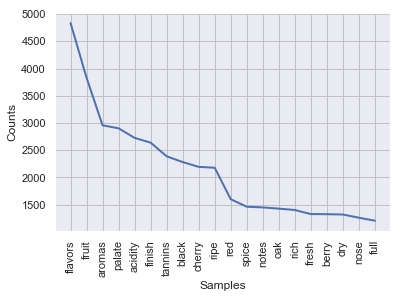

In [0]:
words_freqdist.plot(20, cumulative=False);

## TF-IDF

In [0]:
vectorizer = TfidfVectorizer()
tf_idf_clean_desc_w_stop = vectorizer.fit_transform(clean_desc_w_stop)

In [0]:
tf_idf_clean_desc_w_stop.shape

(10000, 11285)

In [0]:
# Get the count of explicitly-stored values (nonzeros)
tf_idf_clean_desc_w_stop.nnz  

341134

In [0]:
#calculate the frequency
# word_frequency = pd.Series(' '.join(wine_sample['clean_desc']).split()).value_counts()[:20]
# word_frequency

In [0]:
wine_data['taster_name'].value_counts()

Unknown               24912
Roger Voss            23558
Michael Schachner     14045
Kerin O’Keefe         9679 
Paul Gregutt          8867 
Virginie Boone        8707 
Matt Kettmann         5729 
Joe Czerwinski        4765 
Sean P. Sullivan      4460 
Anna Lee C. Iijima    4017 
Jim Gordon            3766 
Anne Krebiehl MW      3289 
Lauren Buzzeo         1700 
Susan Kostrzewa       1022 
Mike DeSimone         461  
Jeff Jenssen          436  
Alexander Peartree    383  
Carrie Dykes          129  
Fiona Adams           24   
Christina Pickard     6    
Name: taster_name, dtype: int64

In [0]:
wine_df

,wineid,country,description,designation,points,price,province,region_1,region_2,taster_name,...,tree,geranium,plastic,lactic,concord,asparagus,garlic,horsey,wool,petroleum
0,0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,0.0,Sicily & Sardinia,Etna,Unknown,Kerin O’Keefe,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",Avidagos,87,15.0,Douro,Unknown,Unknown,Roger Voss,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",Unknown,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Unknown,Alexander Peartree,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10035,10035,Italy,"A blast of ripe stone fruit accompanies whiffs of saline and balsamic herbs. The juicy palate boasts yellow peach, pink grapefruit and pear with hints of sage and eucalyptus. Mineral marks the finish.",Unknown,89,30.0,Southern Italy,Greco di Tufo,Unknown,Kerin O’Keefe,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10036,10036,France,"This sweet wine is full of lychee fruit and the lightest touch of acidity. It's on the light side and has freshness and a crisp edge, bringing out baked apple as well as peaches and a final lightly honeyed texture. Drink now.",Clos St Sébastien,89,35.0,Alsace,Alsace,Unknown,Roger Voss,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10037,10037,US,"Fresh pear and lemon aromas are brightened with hints of white florals on this brisk, medium-bodied wine. Off dry in style, it's juicy on the palate with concentrated white peach flavors accented with honey and tea notes. It's an elegant yet easy quaffer at a very reasonable price.",Unknown,89,14.0,New York,Finger Lakes,Finger Lakes,Anna Lee C. Iijima,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10038,10038,France,"From cool, high-altitude vines, this Riesling is aromatic and crisp with a hint of steel and plenty of freshness. Acidity cuts through this already delicious, very fruity wine that is about to move to maturity. Drink now.",Herrenreben,89,20.0,Alsace,Alsace,Unknown,Roger Voss,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Content Based Filtering 

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
cv = CountVectorizer()

In [0]:
cv_mx = cv.fit_transform(wine_sample['flavor_words_str'])

<BarContainer object of 10 artists>

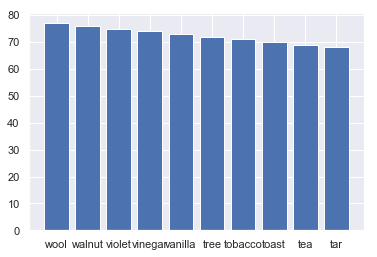

In [0]:
cv_dict = sorted(cv.vocabulary_.items(), reverse=True) 
cv_word, cv_freq = zip(*cv_vocab) # unpack a list of pairs into two tuples
plt.bar(cv_word[:10], cv_freq[:10])

In [0]:
cosine_sim = cosine_similarity(cv_mx, cv_mx)

In [0]:
vectorizer = TfidfVectorizer()
tfidf_mx = vectorizer.fit_transform(wine_sample['flavor_words_str'])

In [0]:
tfidf_cos = cosine_similarity(tfidf_mx, tfidf_mx)

In [0]:
def recommend_wine(wine, wineid, n = 10, cosine_sim = cosine_sim):
    
#     recommend_list = []
    indices = pd.Series(wine.index)
    # retrieve matching movie title index
    if wineid not in wine.index:
        print("Wine not in database.")
        return
    else:
        print("Wine is in database.")
        idx = wine[wine['wineid'] == wineid].index[0]
        print("Flavor:",wine[wine['wineid'] == wineid]['flavor_words'])
#     # cosine similarity scores of movies in descending order
    scores = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    
#     # top n most similar movies indexes
#     # use 1:n because 0 is the same movie entered
    top_n_idx = list(scores.iloc[1:n].index)
        
    return wine['wineid'].iloc[top_n_idx]

In [0]:
recommend_list = recommend_wine(wine_sample, 300, n=5)
recommend_list

Wine is in database.
Flavor: 300    [currant, bacon]
Name: flavor_words, dtype: object


783     783 
2868    2868
5041    5041
8895    8895
Name: wineid, dtype: int64

In [0]:
tfidf_recommend_list = recommend_wine(wine_sample, 300, n=5, cosine_sim = tfidf_cos)
tfidf_recommend_list

Wine is in database.
Flavor: 300    [currant, bacon]
Name: flavor_words, dtype: object


8895    8895
5041    5041
7991    7991
783     783 
Name: wineid, dtype: int64

In [0]:
for item in tfidf_recommend_list:
      print(wine_sample[wine_sample['wineid']==item][['wineid','title','flavor_words',"description"]])

      wineid                                           title  \
8895  8895    Krutz 2008 Krupp Vineyard Malbec (Napa Valley)   

                 flavor_words  \
8895  [fruit, currant, bacon]   

                                                                                                                                                                                                                                                                                                                                         description  
8895  One of the few California Malbecs that comes close to the dense fruit and sheer deliciousness of Argentine bottlings. The wine is full-bodied, soft and insanely rich in blackberry, black currant, cassis, chocolate, bacon and spice flavors, with intense tannins and a fine cut of acidity for balance. This is barbecue wine on steroids.  
      wineid  \
5041  5041     

                                                                  title  \
5041  Gibb

## Collaborative Filtering

In [0]:
wine_sample_user = wine_sample[wine_sample['taster_name']!='Unknown']

In [0]:
wine_sample_user

,wineid,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,clean_desc_w_stop,clean_desc_wo_stop,flavor_words,flavor_words_str
0,0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,0.0,Sicily & Sardinia,Etna,Unknown,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,aromas include tropical fruit broom brimstone and dried herb the palate isn t overly expressive offering unripened apple citrus and dried sage alongside brisk acidity,"[aromas, include, tropical, fruit, broom, brimstone, dried, herb, palate, overly, expressive, offering, unripened, apple, citrus, dried, sage, alongside, brisk, acidity]","[fruit, citrus]",fruit citrus
1,1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",Avidagos,87,15.0,Douro,Unknown,Unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,this is ripe and fruity a wine that is smooth while still structured firm tannins are filled out with juicy red berry fruits and freshened with acidity it s already drinkable although it will certainly be better from,"[ripe, fruity, smooth, still, structured, firm, tannins, filled, juicy, red, berry, fruits, freshened, acidity, already, drinkable, although, certainly, better]",[other],other
2,2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",Unknown,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,tart and snappy the flavors of lime flesh and rind dominate some green pineapple pokes through with crisp acidity underscoring the flavors the wine was all stainless steel fermented,"[tart, snappy, flavors, lime, flesh, rind, dominate, green, pineapple, pokes, crisp, acidity, underscoring, flavors, stainless, steel, fermented]",[other],other
3,3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Unknown,Alexander Peartree,Unknown,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian,pineapple rind lemon pith and orange blossom start off the aromas the palate is a bit more opulent with notes of honey drizzled guava and mango giving way to a slightly astringent semidry finish,"[pineapple, rind, lemon, pith, orange, blossom, start, aromas, palate, bit, opulent, notes, honey, drizzled, guava, mango, giving, way, slightly, astringent, semidry, finish]","[lemon, blossom, honey]",lemon blossom honey
4,4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks,much like the regular bottling from this comes across as rather rough and tannic with rustic earthy herbal characteristics nonetheless if you think of it as a pleasantly unfussy country wine it s a good companion to a hearty winter stew,"[much, like, regular, bottling, comes, across, rather, rough, tannic, rustic, earthy, herbal, characteristics, nonetheles

In [0]:
wine_sample_user= wine_sample_user.assign(id=(wine_sample_user['taster_name']).astype('category').cat.codes)

In [0]:
wine_sample_user = wine_sample_user.rename(columns={'id': 'taster_id'})

In [0]:
wine_sample_user.shape

(8024, 19)

In [0]:
wine_user_rating = wine_sample_user.pivot_table(index = ["wineid"],columns = ['taster_id'],values = "points")
user = wine_user_rating[7]
similarity_with_other_user = wine_user_rating.corrwith(user)  
similarity_with_other_user = similarity_with_other_user.sort_values(ascending=False)
similarity_with_other_user.head()

taster_id
7    1.0
0   NaN 
1   NaN 
2   NaN 
3   NaN 
dtype: float64

In [0]:
user_wine_rating = wine_sample_user.pivot_table(index = ["taster_id"],columns = ['wineid'],values = "points")
wine = user_wine_rating[7]
similarity_with_other_wine = user_wine_rating.corrwith(wine)
similarity_with_other_wine = similarity_with_other_wine.sort_values(ascending=False)
similarity_with_other_wine.head()

## surprise

In [0]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split, cross_validate
from surprise import BaselineOnly
from surprise import Reader
from surprise import NormalPredictor
from surprise import KNNWithMeans, KNNBasic
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from tabulate import tabulate

import time
import datetime
import random

In [0]:
# 載入內建 movielens-100k 資料集
reader = Reader(rating_scale=(80, 100))
wine = Dataset.load_from_df(wine_sample_user[['taster_id', 'wineid', 'points']], reader)
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(wine, test_size=.25)

In [0]:
kf = KFold(random_state=0)

In [0]:
cross_validate(NormalPredictor(), wine, cv=2)

{'test_rmse': array([4.21311217, 4.21286821]),
 'test_mae': array([3.39556792, 3.37683578]),
 'fit_time': (0.007860898971557617, 0.00730586051940918),
 'test_time': (0.052351951599121094, 0.0434720516204834)}

In [0]:
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 2.8290


2.8290151470880867

In [0]:
algo = SVDpp()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 2.8311


2.831067963939011

In [0]:
stable = 'http://surprise.readthedocs.io/en/stable/'
LINK = {'SVD': '[{}]({})'.format('SVD',
                                 stable +
                                 'matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD'),
        'SVDpp': '[{}]({})'.format('SVD++',
                                   stable +
                                   'matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp'),
        'NMF': '[{}]({})'.format('NMF',
                                 stable +
                                 'matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF'),
        'SlopeOne': '[{}]({})'.format('Slope One',
                                      stable +
                                      'slope_one.html#surprise.prediction_algorithms.slope_one.SlopeOne'),
        'KNNBasic': '[{}]({})'.format('k-NN',
                                      stable +
                                      'knn_inspired.html#surprise.prediction_algorithms.knns.KNNBasic'),
        'KNNWithMeans': '[{}]({})'.format('Centered k-NN',
                                          stable +
                                          'knn_inspired.html#surprise.prediction_algorithms.knns.KNNWithMeans'),
        'KNNBaseline': '[{}]({})'.format('k-NN Baseline',
                                         stable +
                                         'knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline'),
        'CoClustering': '[{}]({})'.format('Co-Clustering',
                                          stable +
                                          'co_clustering.html#surprise.prediction_algorithms.co_clustering.CoClustering'),
        'BaselineOnly': '[{}]({})'.format('Baseline',
                                          stable +
                                          'basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly'),
        'NormalPredictor': '[{}]({})'.format('Random',
                                             stable +
                                             'basic_algorithms.html#surprise.prediction_algorithms.random_pred.NormalPredictor'),
        'ml-100k': '[{}]({})'.format('Movielens 100k',
                                     'http://grouplens.org/datasets/movielens/100k'),
        'ml-1m': '[{}]({})'.format('Movielens 1M',
                                   'http://grouplens.org/datasets/movielens/1m'),
        }

In [0]:
classes = (SVD, SVDpp, NMF, SlopeOne, KNNBasic, KNNWithMeans, KNNBaseline,
           CoClustering, BaselineOnly, NormalPredictor)

# classes = (SVD, SVDpp, KNNBasic, KNNWithMeans, KNNBaseline)

In [0]:
table = []
for klass in classes:
    start = time.time()
    out = cross_validate(klass(), wine, ['rmse', 'mae'], kf)
    cv_time = str(datetime.timedelta(seconds=int(time.time() - start)))
    link = LINK[klass.__name__]
    mean_rmse = '{:.3f}'.format(np.mean(out['test_rmse']))
    mean_mae = '{:.3f}'.format(np.mean(out['test_mae']))

    new_line = [link, mean_rmse, mean_mae, cv_time]
    print(tabulate([new_line], tablefmt="pipe"))  # print current algo perf
    table.append(new_line)

|:----------------------------------------------------------------------------------------------------------------------------------|------:|------:|:--------|
| [SVD](http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) | 2.824 | 2.302 | 0:00:03 |
|:--------------------------------------------------------------------------------------------------------------------------------------|------:|------:|:--------|
| [SVD++](http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp) | 2.825 | 2.304 | 0:08:35 |
|:----------------------------------------------------------------------------------------------------------------------------------|------:|------:|:--------|
| [NMF](http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF) | 2.979 | 2.443 | 0:00:05 |
|:------------------------------

In [0]:
header = ['wine_sample 10k',
          'RMSE',
          'MAE',
          'Time'
          ]
print(tabulate(table, header, tablefmt="pipe"))

| wine_sample 10k                                                                                                                        |   RMSE |   MAE | Time    |
|:---------------------------------------------------------------------------------------------------------------------------------------|-------:|------:|:--------|
| [SVD](http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)      |  2.824 | 2.302 | 0:00:03 |
| [SVD++](http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp)  |  2.825 | 2.304 | 0:08:35 |
| [NMF](http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF)      |  2.979 | 2.443 | 0:00:05 |
| [Slope One](http://surprise.readthedocs.io/en/stable/slope_one.html#surprise.prediction_algorithms.slope_one.SlopeOne)                 |  2.979 | 2.443 | 0:00:09 |
| [k

## Lemmatizing and Stemming

In [0]:
# Use Stemming

In [0]:
stem_desc = []
for index, row in wine_sample.iterrows():
    split_text = row['clean_desc'].split()
    
    ##Stemming
    stm = SnowballStemmer("english")
    split_text = [stm.stem(word) for word in split_text if not word in stop_words] 
    split_text = " ".join(split_text)
    stem_desc.append(split_text)
    
    #Lemmatisation
#     lem = WordNetLemmatizer()
#     split_text = [lem.lemmatize(word) for word in split_text if not word in stop_words] 
#     split_text = " ".join(split_text)
#     stem_desc.append(split_text)
stem_desc

['pretti citrus tone back white peach soapi floral note produc clean fresh sparkler easi approach beauti crisp smooth citrus flavor leav last impress',
 'pale salmon color copper hint somewhat mute nose subtl aroma ripe red berri fruit crisp lift palat vigor mouss live flavor redcurr wild strawberri cherri medium bodi creami textur persist finish well made complex',
 'second calon gur beauti proport fruiti rich tannin time crisp fruit vintag give lift deep concentr let develop sever year',
 'gritti oili matchstick aroma follow blocki palat apricot peach pit citrus flavor finish last flavor citrus rind tough pithi overal hard plow',
 'beauti intens imposs match enorm complex aroma chocol black tar spice blackberri forest currant tobacco pick toast oak tone well care balanc within natur suppl smooth essenc standout brunello',
 'pinot noir domin intens acid well attract rich white fruit touch matur ripe give full bodi charact add toasti well integr readi',
 'full bodi robust concentr choc

In [0]:
lemm_desc = []
for index, row in wine_sample.iterrows():
    split_text = row['clean_desc'].split()
    
    #Stemming
#     stm = SnowballStemmer("english")
#     split_text = [stm.stem(word) for word in split_text if not word in stop_words] 
#     split_text = " ".join(split_text)
#     stem_desc.append(split_text)
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    split_text = [lem.lemmatize(word) for word in split_text if not word in stop_words] 
    split_text = " ".join(split_text)
    lemm_desc.append(split_text)
lemm_desc

['pretty citrus tone backed white peach soapy floral note produce clean fresh sparkler easy approachable beautifully crisp smooth citrus flavor leave lasting impression',
 'pale salmon color copper hint somewhat muted nose subtle aroma ripe red berry fruit crisp lift palate vigorous mousse lively flavor redcurrant wild strawberry cherry medium bodied creaminess texture persists finish well made complex',
 'second calon gur beautifully proportioned fruity rich tannin time crisp fruit vintage give lift deep concentration let develop several year',
 'gritty oily matchstick aroma followed blocky palate apricot peach pit citrus flavor finish lasting flavor citrus rind tough pithy overall hard plow',
 'beauty intensity impossible match enormous complexity aroma chocolate black tar spice blackberry forest currant tobacco pick toasted oak tone well carefully balanced within naturally supple smooth essence standout brunello',
 'pinot noir dominated intense acidity well attractive rich white fru

In [0]:
wine_sample['clean_desc'].head(1)

126714    pretty citrus tones are backed by white peach and soapy floral notes to produce a clean fresh sparkler that is easy and approachable the wine is beautifully crisp with smooth citrus flavors that leave a lasting impression 
Name: clean_desc, dtype: object

In [0]:
stem_desc[0]

'pretti citrus tone back white peach soapi floral note produc clean fresh sparkler easi approach beauti crisp smooth citrus flavor leav last impress'

In [0]:
lemm_desc[0]

'pretty citrus tone backed white peach soapy floral note produce clean fresh sparkler easy approachable beautifully crisp smooth citrus flavor leave lasting impression'

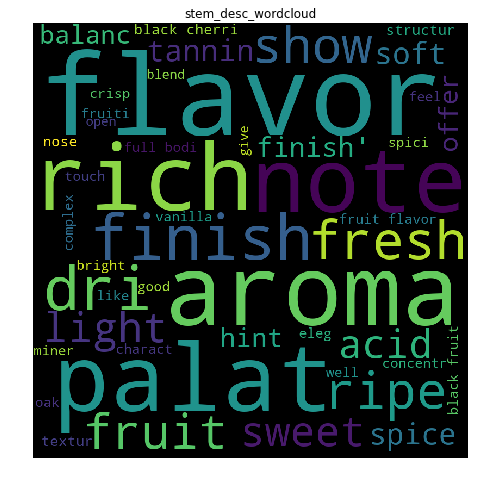

In [0]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'black', stopwords = stop_words, max_words = 1000, min_font_size = 20).generate(str(stem_desc))
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.title("stem_desc_wordcloud")
plt.axis('off')
plt.show()
#fig.savefig("stem_desc_wordcloud.png")

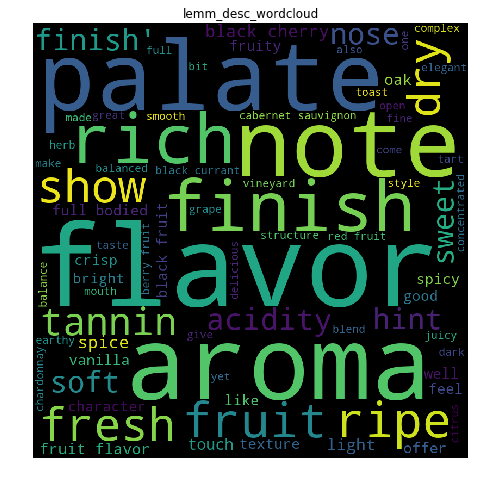

In [0]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'black', stopwords = stop_words, max_words = 1000, min_font_size = 20).generate(str(lemm_desc))
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.title("lemm_desc_wordcloud")
plt.axis('off')
plt.show()

#fig.savefig("lemm_desc_wordcloud.png", dpi=900)

## Analyzing n-grams
analyzing three-word groups

In [0]:
clean_desc[0]

'pretty citrus tones are backed by white peach and soapy floral notes to produce a clean fresh sparkler that is easy and approachable the wine is beautifully crisp with smooth citrus flavors that leave a lasting impression '

In [0]:
def get_bigrams(descriptions, n=None):
    
    vec = CountVectorizer(ngram_range = (2,2), max_features = 20000).fit(descriptions)
    bag_of_words = vec.transform(descriptions)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse = True)
   
    return words_freq[:n]

#run the function on the processed descriptions
bigrams = get_bigrams(clean_desc, n=15)
#create a trigram data frame
bigram_df = pd.DataFrame(bigrams)
bigram_df.columns=["Bigram", "Freq"]
#output top 15 rows
bigram_df.head(15)

,Bigram,Freq
0,on the,2550
1,the palate,1838
2,this is,1831
3,this wine,1428
4,aromas of,1342
5,the finish,1308
6,in the,1277
7,the wine,1271
8,flavors of,1228
9,the nose,988


In [0]:
def get_trigrams(descriptions, n=None):
    
    vec = CountVectorizer(ngram_range = (3,3), max_features = 20000).fit(descriptions)
    bag_of_words = vec.transform(descriptions)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse = True)
   
    return words_freq[:n]

#run the function on the processed descriptions
trigrams = get_trigrams(clean_desc, n=15)
#create a trigram data frame
trigram_df = pd.DataFrame(trigrams)
trigram_df.columns=["Trigram", "Freq"]
#output top 15 rows
trigram_df.head(15)

,Trigram,Freq
0,on the palate,696
1,on the finish,633
2,on the nose,578
3,the palate is,428
4,the wine is,413
5,in the mouth,371
6,this wine is,337
7,ready to drink,299
8,as well as,268
9,the finish is,233


In [0]:
def get_quadgrams(descriptions, n=None):
    
    vec = CountVectorizer(ngram_range = (4,4), max_features = 20000).fit(descriptions)
    bag_of_words = vec.transform(descriptions)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse = True)
   
    return words_freq[:n]

#run the function on the processed descriptions
quadgrams = get_quadgrams(clean_desc, n=15)
#create a trigram data frame
quadgram_df = pd.DataFrame(quadgrams)
quadgram_df.columns=["Quadgram", "Freq"]
#output top 15 rows
quadgram_df.head(15)

,Quadgram,Freq
0,the nose of this,190
1,on the palate with,144
2,on the nose of,142
3,is ready to drink,100
4,the nose the palate,95
5,opens with aromas of,92
6,on the nose the,87
7,on the nose with,74
8,the nose on this,74
9,blend of cabernet sauvignon,73


In [0]:
stops = ['wine', 'the', 'drink', 'an','a', 'cabernet', 'sauvignon', 'black', 'cherry']

stem_desc = []
for index, row in wine_sample.iterrows():
# for w in range(len(wine_df['clean_desc'])):
    split_text = row['clean_desc'].split()   
    #Lemmatisation
    #lem = WordNetLemmatizer()
    split_text = [lem.lemmatize(word) for word in split_text if not word in stops] 
    split_text = " ".join(split_text)
    stem_desc.append(split_text)


trigrams_stops = get_trigrams(stem_desc , n=15)
#create a trigram data frame
trigrams_stops_df = pd.DataFrame(trigrams_stops)
trigrams_stops_df.columns=["Trigram", "Freq"]
#output top 15 rows
trigrams_stops_df.head(15)

,Trigram,Freq
0,and hint of,223
1,nose of this,212
2,this blend of,177
3,with aroma of,173
4,with hint of,172
5,with note of,170
6,this open with,148
7,on palate with,144
8,on nose of,143
9,aroma and flavor,139


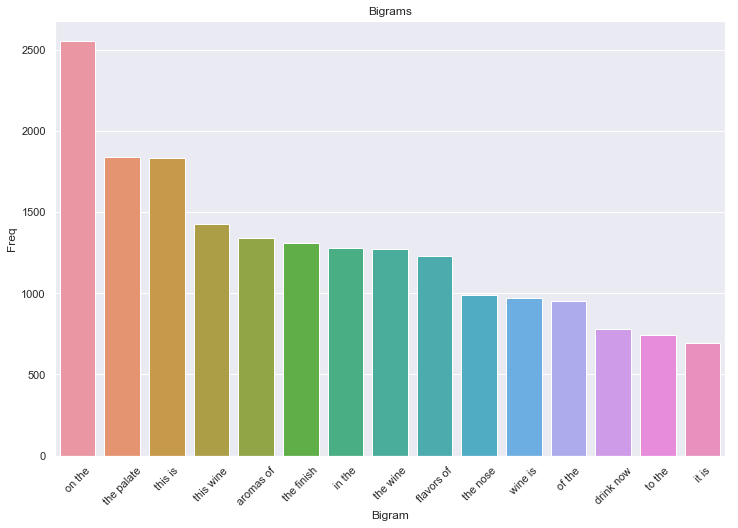

In [0]:
fig = sns.set(rc = {'figure.figsize':(12,8)})
bp = sns.barplot(x = "Bigram", y = "Freq", data = bigram_df)
bp.set_xticklabels(bp.get_xticklabels(), rotation = 45)
plt.title("Bigrams")
plt.show()

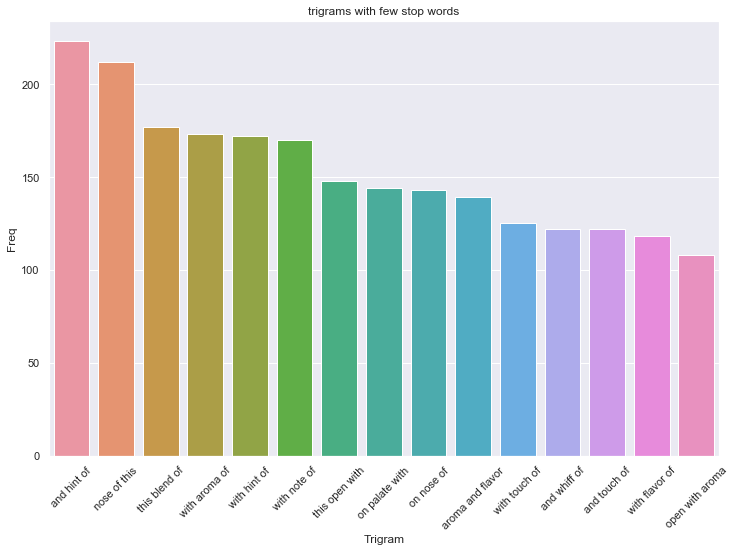

In [0]:
fig = sns.set(rc = {'figure.figsize':(12,8)})
bp = sns.barplot(x = "Trigram", y = "Freq", data = trigrams_stops_df)
bp.set_xticklabels(bp.get_xticklabels(), rotation = 45)
plt.title("trigrams with few stop words")
plt.show()

In [0]:
#creat a table in the database
wine_data.to_sql('wine_data', conn, if_exists = "replace")
#read the table in the database
wine_df = pd.read_sql('Select * from wine_data', conn)

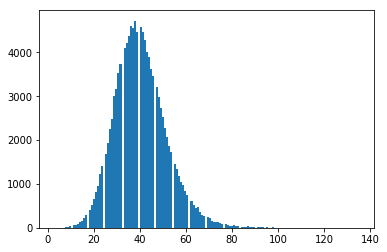

In [0]:
#create a column named color
wine_df["color"] = ""

In [0]:
pd.read_sql("""
SELECT variety, count(variety) as vcount 
FROM wine_data
GROUP BY variety
"""
, conn)

,variety,vcount
0,None,0
1,Abouriou,3
2,Agiorgitiko,63
3,Aglianico,359
4,Aidani,1
...,...,...
703,Zinfandel,2714
704,Zlahtina,2
705,Zweigelt,209
706,Çalkarası,2


## Converting to a matrix of integers

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
vectorizer = TfidfVectorizer()
tf_idf_data = vectorizer.fit_transform(trigram_df)

In [0]:
tf_idf_data.shape

(2, 2)

In [0]:
type(clean_desc)

list

In [0]:
len(clean_desc)

10000

In [0]:
len(clean_desc[1])

324

In [0]:
len(stop_words)

181

In [0]:
def process_article(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed  

In [0]:
processed_data = list(map(process_article, data))